# Environment Setup

In [ ]:
# Might need to run these in Jupyter the first time this is run for sksurv 
# !pip install cmake
# !pip install scikit-survival

In [27]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.transform import resize
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.nonparametric import kaplan_meier_estimator
import sys
import tensorflow as tf 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, Input, MaxPool2D
from tensorflow.keras.optimizers import Adam
import tensorflow.compat.v2.summary as summary
from tensorflow.python.ops import summary_ops_v2
from tqdm import tqdm
from typing import Any, Dict, Iterable, Sequence, Tuple, Optional, Union


In [36]:
# sys.path.append(".")

from patient_data_split import pat_train_test_split
from input_function import InputFunction
import cph_loss
import cindex_metric

In [ ]:
# pip install import_ipynb

# Data Loading and Setup

In [2]:
# Constants for development
FILESTOLOAD = 100
imdim_from_preprocessing = 299 # must match opt.ImageSize in image preprocessing configuration files
imdim_for_network = 1024
random_seed = 16

In [3]:
# Path to CSVs that connect patient id to slices and rfs label
zero_info_path = '/Users/katyscott/Documents/ICC/Data/Labels/RFS_all_tumors_zero.csv'
nan_info_path = '/Users/katyscott/Documents/ICC/Data/Labels/RFS_all_tumors_NaN.csv'

zero_image_path = '/Users/katyscott/Documents/ICC/Data/Images/Tumors/' + str(imdim_from_preprocessing) + '/Zero/'
nan_image_path = '/Users/katyscott/Documents/ICC/Data/Images/Tumors/' + str(imdim_from_preprocessing) + '/NaN/'


In [4]:
# Reading in info for zero background images
info = pd.read_csv(zero_info_path)
image_fnames = np.asarray(info.iloc[:, 0])
pat_num = np.asarray(info.iloc[:, 1])
slice_num = np.asarray(info.iloc[:, 2])
rfs_event = np.asarray(info.iloc[:, 3])
rfs_time = np.asarray(info.iloc[:, 4])

print(rfs_event.shape)
print(rfs_time[1])

(2888,)
0.6


In [5]:
# Only loading in 100 number of files for development
images = np.empty((1,imdim_for_network,imdim_for_network))
file_count = 0
for image_file in tqdm(image_fnames):
    if file_count >= FILESTOLOAD:
        break
    else:
        file_count += 1
    #     print("Loading: ", image_file)
        # Load in file as an numpy array
        img = np.fromfile(zero_image_path + image_file)
        # Reshape image from 1D to 2D array - need to not hardcode this, square root?
        img_2D = np.reshape(img, (imdim_from_preprocessing,imdim_from_preprocessing))
        # Scale image to this dimension, smooth image with Gaussian filter, pads with the reflection of the vector
        # mirrored on the first and last values of the vector along each axis.
        img_final = resize(img_2D, (imdim_for_network, imdim_for_network), anti_aliasing=True, mode='reflect')
        # Not sure this next line is working, want an array with all the images as their own array in it
        img_final_3D = np.reshape(img_final, (1,) + img_final.shape)
        images = np.append(images, img_final_3D, axis=0)

images = np.delete(images, 0, axis=0)

  3%|▎         | 100/2888 [00:29<13:41,  3.39it/s]


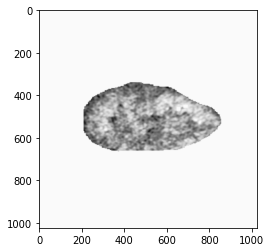

In [6]:
# Confirming images loaded in properly
plt.imshow(images[5], cmap='Greys')

## Splitting data for training/testing

In [15]:
# Training and testing split
train_slice_indices, test_slice_indices = pat_train_test_split(pat_num[:FILESTOLOAD], rfs_event[:FILESTOLOAD], 0.7, random_seed)

print("Train: ", np.array(train_slice_indices).shape)
print("Test: ", np.array(test_slice_indices).shape)

Train:  (1, 73)
Test:  (1, 27)


In [9]:
train_slices = images[train_slice_indices,:,:]#[:][:]
train_slices = train_slices.squeeze() # Remove first dim of size 1

train_time = rfs_time[tuple(train_slice_indices)]
train_event = rfs_event[tuple(train_slice_indices)]
print("Training set: ", train_slices.shape)
print("Training time labels: ", train_time.shape)
print("Training event labels: ", train_event.shape)

test_slices = images[test_slice_indices,:,:]
test_slices = test_slices.squeeze() # Remove first dim of size 1

test_time = rfs_time[tuple(test_slice_indices)]
test_event = rfs_event[tuple(test_slice_indices)]
print("Testing set: ", test_slices.shape)
print("Testing time labels: ", test_time.shape)
print("Testing event labels: ", test_event.shape)


Training set:  (73, 1024, 1024)
Training time labels:  (73,)
Training event labels:  (73,)
Testing set:  (27, 1024, 1024)
Testing time labels:  (27,)
Testing event labels:  (27,)


## Data Exploration

Text(0.5, 1.0, 'Kaplan-Meier Survival Curve')

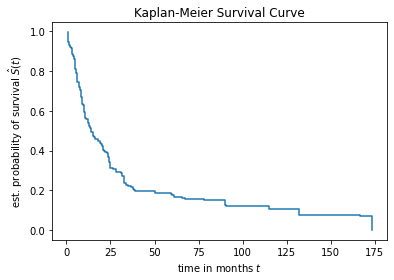

In [11]:
# Convert rfs_event from numeric to boolean for use in sksurv
b_rfs_event = np.array(rfs_event, dtype=bool)
# Creating structured array for kaplan_meier_estimator
rfs_type = np.dtype([('Status','bool'), ('Time', 'f')])
rfs = np.empty(len(rfs_event),dtype=rfs_type)
rfs['Status'] = b_rfs_event
rfs['Time'] = rfs_time

time, survival_prob = kaplan_meier_estimator(rfs['Status'], rfs['Time'])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time in months $t$")
plt.title("Kaplan-Meier Survival Curve")

In [19]:
train_time.shape

(73,)

In [32]:
risk_time = _make_riskset(train_time)

train_fn = InputFunction(train_slices, train_time, train_event, shuffle = True)

# Model Setup

## Survival Analysis for Deep Learning tutorial - Sebastian Pölsterl

https://k-d-w.org/blog/2019/07/survival-analysis-for-deep-learning/

Tensorflow 2 version of code

https://nbviewer.jupyter.org/github/sebp/survival-cnn-estimator/blob/master/tutorial_tf2.ipynb

In [ ]:
model = Sequential([
        Conv2D(6, kernel_size=(5,5), activation='relu', name='conv_1'),
        MaxPool2D(pool_size=(2,2)),
        Conv2D(16, (5,5), activation='relu', name='conv_2'),
        MaxPool2D(pool_size=(2,2)),
        Flatten(),
        Dense(120, activation='relu', name='dense_1'),
        Dense(84, activation='relu', name='dense_2'),
        Dense(1, activation='linear', name='dense_3')
    ])

In [ ]:
train_fn = InputFunction(x_train, time_train, event_train, drop_last = True, shuffle=True)

## DeepConvSurv 
(Zhu, Yao, & Huang, 2016)

https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7822579&casa_token=gVFzncUVfTgAAAAA:hGgPWCTzS2pUnsFG8xEZzZe7lAIupB_Z7SkKDnFJbilFmX1W6Ge5qCipPjiqCynL1lfSs64bVV4

In [ ]:
img_in = Input(shape=(imdim_for_network, imdim_for_network,1))

network = Conv2D(filters=32, kernel_size=686, activation='relu', padding='valid')(img_in)
network = MaxPool2D(pool_size=(2,2))(network)

network = Conv2D(filters=32, kernel_size=88, activation='relu', padding='valid')(network)
network = Conv2D(filters=32, kernel_size=43, activation='relu', padding='valid')(network)

network = MaxPool2D(pool_size=(2,2))(network)

network = Flatten()(network)
network = Dense(32, activation='relu')(network)
output = Dense(1, activation='exponential')(network)

model = Model(inputs=img_in, outputs=output, name="deepconvsurv")
model.compile(
        optimizer = Adam(),
        loss='binary_crossentropy'
)
model.summary()

## Model Training

In [ ]:
print("Training model: " + model.name)

epochs = 10
batch_size = 32

history = model.fit(x = train_slices,
                    y = train_labels,
                    batch_size = batch_size,
                    validation_split = 0.15,
                    epochs = epochs,
                    verbose = 1 
                    )

In [ ]:
# Create AUC metric vs. epoch plot
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model accuracy - ' + model.name)
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()